In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import bootstrap
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from sklearn.utils import resample

%matplotlib inline

## Общее описание:
Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения.

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Проведем работу с данными для создания необходимых датасетов
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем    
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было

In [2]:
ab_users_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/statistics/lesson_9/ab_users_data.csv')
ab_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/statistics/lesson_9/ab_orders.csv')
ab_products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-v-tsuzoj/statistics/lesson_9/ab_products.csv')

In [3]:
ab_users_data.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
ab_users_data = ab_users_data.query("action == 'create_order'")

In [5]:
ab_users_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4123 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4123 non-null   int64 
 1   order_id  4123 non-null   int64 
 2   action    4123 non-null   object
 3   time      4123 non-null   object
 4   date      4123 non-null   object
 5   group     4123 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 225.5+ KB


In [6]:
ab_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [7]:
ab_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [8]:
ab_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [9]:
ab_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


Поработаем с `price_df`, удалив столбец name, так как на мой взгляд наименование товара не так важно в моем исследовании, поэтому оставим товары только по `product_id`

In [10]:
price_df = ab_products.drop('name', axis = 1)
products_dict = price_df.set_index('product_id')['price'].to_dict()

Теперь подготовим ДФ `df_orders`, и посчитаем общую стоимость каждого заказа `total_cost` и количество товаров в одном заказе `products_count`

In [11]:
df_orders = ab_orders.copy()
df_orders['product_ids'] = df_orders['product_ids'].str.strip('{}').str.split(',')
df_orders['product_ids'] = df_orders['product_ids'].apply(lambda x: [int(i) for i in x])
df_orders['total_cost'] = df_orders['product_ids'].apply(lambda x: sum([products_dict[i] for i in x]))
df_orders['products_count'] = df_orders['product_ids'].apply(lambda x: len(x))

df_orders = df_orders.drop('creation_time', axis = 1)
df_orders.head()

,order_id,product_ids,total_cost,products_count
0,1255,"[75, 22, 53, 84]",408.7,4
1,1256,"[56, 76, 39]",250.5,3
2,1257,"[76, 34, 41, 38]",310.2,4
3,1258,"[74, 6]",85.0,2
4,1259,"[20, 45, 67, 26]",228.0,4


Теперрь подготовлю итоговый ДФ `df_ab`, который буду использовать для проверки гипотез и A/B тестов

In [12]:
df_ab = pd.merge(ab_users_data, df_orders, how = 'left', on = 'order_id')
df_ab = df_ab.drop(['action', 'time', 'date', 'product_ids'], axis = 1)

df_ab.head()

,user_id,order_id,group,total_cost,products_count
0,964,1255,0,408.7,4
1,965,1256,1,250.5,3
2,964,1257,0,310.2,4
3,966,1258,0,85.0,2
4,967,1259,1,228.0,4


In [13]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4123 entries, 0 to 4122
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         4123 non-null   int64  
 1   order_id        4123 non-null   int64  
 2   group           4123 non-null   int64  
 3   total_cost      4123 non-null   float64
 4   products_count  4123 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 193.3 KB


# Графики, гипотизы, тесты

### 1) Посмотрим на то, как увеличилось число заказов на пользователя в контрольной и тестовой группах на 1 пользователя

Подготовим ДФ и посчитаем количество заказов `orders` для каждого юзера

In [14]:
df_aoc = df_ab.groupby(['group','user_id'], as_index = False) \
              .agg({'order_id' : 'nunique'}) \
              .rename(columns = {'order_id' : 'orders'})

df_aoc.head()

,group,user_id,orders
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1


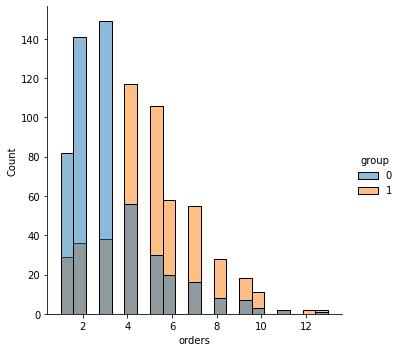

In [15]:
sns.displot(data = df_aoc, x = "orders", hue = "group")

#### Судя по графику, число заказов на пользователя в тестовой группе, увеличилось. Однако делать выводы только по графику не очень хорошо, поэтому сформулируем следующие гипотизы:

Для проверки среднего в двух группах будем использовать `t-test`, даже не смотря на то, что распределение является ненормальным.

- $H_0$: среднее число заказов на 1 пользователя в контрольной и тестовой группах не отличаются
- $H_1$: отличия есть

In [16]:
# Выполнение t-test
statistic, p_value = ttest_ind(df_aoc.query("group == 0")['orders'], df_aoc.query("group == 1")['orders'])

# Вывод результатов
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: -14.51086812343365
p-value: 1.6974865514796019e-43


#### Получившееся `p-value < 0.05`, поэтому следует отклонить $H_0$ и принять $H_1$.

### --------------------------------------------------------------------------------------------------------------------------------------------------------

### 2) Теперь интересно посмотреть на то, изменилась ли метрика AOV (Average Order Value)

Подготовим ДФ, в котором создадим новый столбец AOV с расчетом на каждого пользователя

In [17]:
df_aov = df_ab.groupby(['group', 'user_id'], as_index = False) \
              .agg({'order_id' : 'nunique', 'total_cost' : 'sum'}) \
              .rename(columns = {'order_id' : 'orders'})
df_aov['AOV'] = df_aov['total_cost'] / df_aov['orders']

df_aov.head()

,group,user_id,orders,total_cost,AOV
0,0,964,2,718.9,359.450000
1,0,966,1,85.0,85.000000
2,0,968,3,1590.7,530.233333
3,0,969,2,681.9,340.950000
4,0,972,1,546.4,546.400000


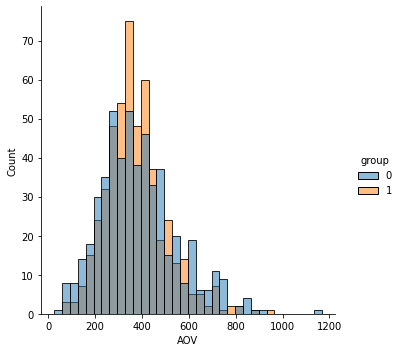

In [18]:
sns.displot(data = df_aov, x = "AOV", hue = "group")

#### Проверим, является ли распределение AOV нормальным, для этого применим `тест Шапиро-Уилка`

In [19]:
shapiro(df_aov.AOV)

ShapiroResult(statistic=0.9630125761032104, pvalue=2.195483988294729e-15)

`p-value < 0.05`. Следовательно нулевая гипотеза о нормальности распределения отклоняется.

#### Судя по графику, особо сильных различий в AOV на пользователя не наблюдается. Однако попробуем провести статистический тест, поэтому сформулируем следующие гипотизы:

Поскольку распределение не нормальное, а переменные - количественные → используем `t-test` (также попробую применить bootstrap - анализ).

- $H_0$: AOV на 1 пользователя в контрольной и тестовой группах не отличаются
- $H_1$: отличия есть

In [20]:
# Выполнение t-test
statistic, p_value = ttest_ind(df_aov.query("group == 0")['AOV'], df_aov.query("group == 1")['AOV'])

# Вывод результатов
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 1.1434040168228712
p-value: 0.25314048853144


При использовании `t-test` получившееся `p-value ~ 0.25, что больше 0.05`, поэтому предположение о равности AOV в двух группах верно. Не отклоняем гипотезу $H_0$.

Однако, хочу попробовать применить `bootstrap-анализ` и посмотреть на его результаты.

In [21]:
aov_bootstrap = df_aov.copy()

In [22]:
aov_bootstrap = aov_bootstrap.drop(['user_id', 'orders', 'total_cost'], axis = 1)

In [23]:
control_aov = aov_bootstrap.query("group == 0")
test_aov = aov_bootstrap.query("group == 1")

С использованием bootstrap-анализа будем сравнивать среднее в AOV

In [24]:
control_aov.AOV.mean()

383.19340550010935

In [25]:
test_aov.AOV.mean()

372.6325963229997

In [26]:
# Данные двух групп
group_1 = np.array(control_aov.AOV)
group_2 = np.array(test_aov.AOV)

# Размер выборки для bootstrap
n_iterations = 10000

# Список для сохранения разницы между средними значениеми bootstrap выборок
bootstrap_diff = []

# Выполняем bootstrap и сохраняем разницу между средними значениеми выборок
for _ in range(n_iterations):
    sample1 = resample(group_1, replace = True)
    sample2 = resample(group_2, replace = True)
    bootstrap_diff.append(np.mean(sample1) - np.mean(sample2))

# Вычисляем p-value
observed_diff = np.mean(group_1) - np.mean(group_2)
p_value = (np.abs(bootstrap_diff) >= np.abs(observed_diff)).mean()

# Выводим результат
if p_value < 0.05:
    print("Разница между группами статистически значима.")
else:
    print("Разница между группами не является статистически значимой.")

Разница между группами не является статистически значимой.


Bootstrap-подход также продемонстрировал, что разница между группами не является статистически значимой, поэтому принимаем нулевую гипотезу о равности AOV в двух группах

### --------------------------------------------------------------------------------------------------------------------------------------------------------

### 3) Теперь посмотрим, увеличилось ли количество среднее количество товаров в чеке на пользователя

Подготовим ДФ в котором сагрегируем данные по группе и по пользователям и рассчитаем количество купленных товаров для каждого пользователя `products_count`

In [27]:
products_in_check = df_ab.groupby(['group', 'order_id'], as_index = False) \
                       .agg({'products_count' : 'sum'})

In [28]:
products_in_check

,group,order_id,products_count
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4
...,...,...,...
4118,1,59220,4
4119,1,59250,3
4120,1,59390,5
4121,1,59422,3


In [29]:
control_products_in_check =  products_in_check.query("group == 0")['products_count'].sum() \
                           / products_in_check.query("group == 0")['order_id'].nunique()
control_products_in_check

3.3499067743940336

In [30]:
test_orders_in_check =  products_in_check.query("group == 1")['products_count'].sum() \
                        / products_in_check.query("group == 1")['order_id'].nunique()
test_orders_in_check

3.3556085918854417

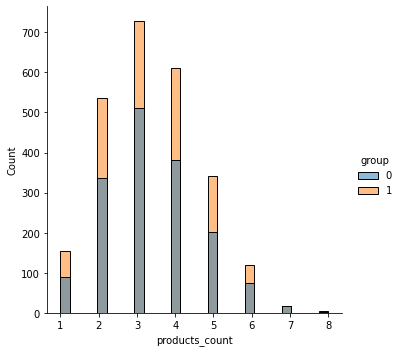

In [31]:
sns.displot(data = products_in_check, x = "products_count", hue = "group")

#### Судя по полученному распределнию, количество товаров в чеке на пользователя в тестовой группе, увеличилось. 

Применим `t-test`.

- $H_0$: среднее число товаров в чеке на 1 пользователя в контрольной и тестовой группах не отличаются
- $H_1$: отличия есть

In [32]:
# Выполнение t-test
statistic, p_value = ttest_ind(products_in_check.query("group == 0")['products_count'], 
                                  products_in_check.query("group == 1")['products_count'])
# Вывод результатов
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: -0.1380397717649213
p-value: 0.8902157292521864


#### Получившееся `p-value > 0.05`, поэтому $H_0$ не отклоняем.

## Выводы:

1. **Полученная статистика свидетельствует о том, что число заказов в тестовой группе для каждого пользователя увеличилось, следовательно в этом плане новая система рекомендаций эффективнее, чем старая**
2. **AOV особо сильно не изменился, и даже немного уменьшился, и находится примерно на том же уровне, что и в старой системе рекомендаций.**
3. **Количество товаров в чеке (позиций в чеке) в среднем не увеличилось, что подтверждено статистическим тестом.**



**Подводим итоги:**
   Рассматриваемые мною метрики: количество заказов и количество товаров в чеке на 1 пользователя с применением новой системы рекомендации товаров увеличились, однако, это не сильно повлияло на увеличение метрики AOV, и наоборот, даже немного снизило ее.